# ANDES Demonstration of `DGPRCTExt` on IEEE 14-Bus System

Prepared by Jinning Wang. Last revised 12 September 2021.

## Background

Voltage signal is set manually to demonstrate ANDES `DGPRCTExt`.

In the modified IEEE 14-bus system, 10 `PVD1` are conencted to `Bus4`, and 1 `DGPRCTExt` is added aiming at `PVD1_2`.

## Conclusion

`DGPRCTExt` can be used to implement protection on `DG` models, where the voltage signal can be read from outside.

In [17]:
import andes
from andes.utils.paths import get_case

andes.config_logger(stream_level=30)

In [18]:
ss = andes.load(get_case('ieee14/ieee14_dgprctext.xlsx'), setup=False,
                no_output=True)

In [19]:
ss.setup()

True

In [20]:
# use constant power model for PQ
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ss.PQ.pq2z = 0
ss.PFlow.run()

True

## Simulation
Let's run the simulation and manipulate the voltage signal manually.
1) run the TDS to 1s.

In [21]:
ss.TDS.config.tf = 1
ss.TDS.run()

TGOV1.LAG_lim at limits <VMIN>

  idx    | Flag | Input Value | Limit
---------+------+-------------+------
 TGOV1_2 | zl   | 0.300       | 0.300
 TGOV1_3 | zl   | 0.300       | 0.300




100%|███████████████████████████████| 100/100 [00:00<00:00, 457.37%/s]


True

2) store initial Bus4voltage value.

In [22]:
bus4v0 = ss.Bus.v.v[3]

3) set the external voltage at 0.7 manually.

In [23]:
ss.DGPRCTExt.set(src='v', idx='DGPRCTExt_1', attr='v', value=0.7)

True

4) continue the TDS to 5s.

In [24]:
ss.TDS.config.tf = 5
ss.TDS.run()

100%|█████████████████████████████| 100.0/100 [00:00<00:00, 151.56%/s]


True

5) reset the external voltage back to normal manually.

In [25]:
ss.DGPRCTExt.set(src='v', idx='DGPRCTExt_1', attr='v', value=bus4v0)

True

6) continue the TDS to 10s.

In [26]:
ss.TDS.config.tf = 10
ss.TDS.run()

100%|██████████████████████████████| 100.0/100 [00:01<00:00, 89.28%/s]


True

## Results

### system frequency

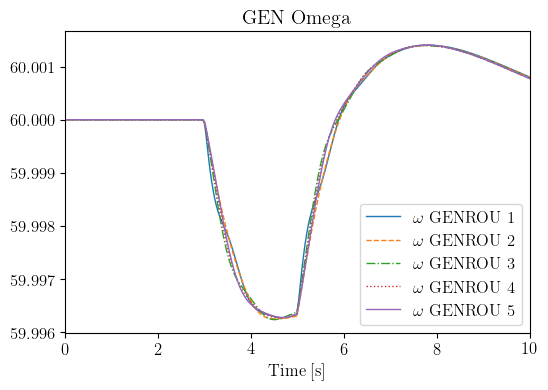

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'GEN Omega'}, xlabel='Time [s]'>)

In [27]:
ss.TDS.plt.plot(ss.GENROU.omega,
                ycalc=lambda x:60*x,
                title='GEN Omega')

### Lock flag

The lock flag is raised at after `TVl1` when the voltage drop below `Vl1`.

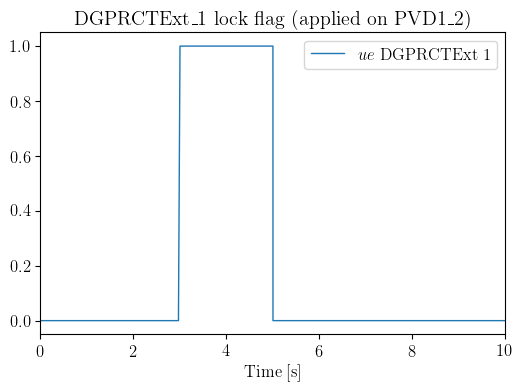

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'DGPRCTExt\\_1 lock flag (applied on PVD1\\_2)'}, xlabel='Time [s]'>)

In [28]:
ss.TDS.plt.plot(ss.DGPRCTExt.ue,
                title='DGPRCTExt\_1 lock flag (applied on PVD1\_2)')

### PVD1_2 read frequency and frequency signal source

The `PVD1_2` read frequency is locked, but the signal source (in the `BusFreq 4`) remains unchanged

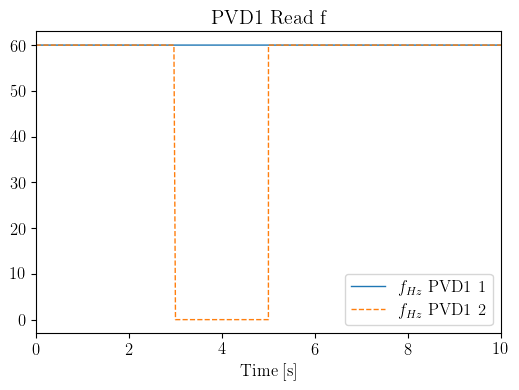

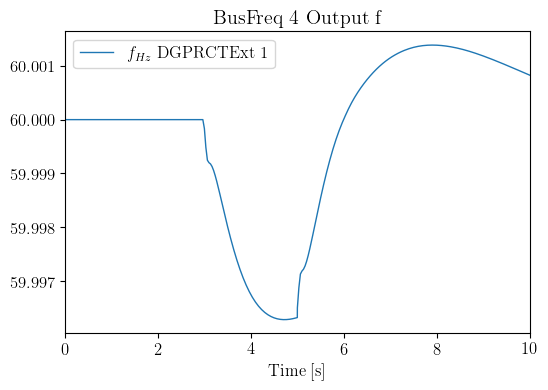

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'BusFreq 4 Output f'}, xlabel='Time [s]'>)

In [29]:
ss.TDS.plt.plot(ss.PVD1.fHz,
                a=(0,1),
                title='PVD1 Read f')

ss.TDS.plt.plot(ss.DGPRCTExt.fHz,
                title='BusFreq 4 Output f')

### PVD1_2 power command

`PVD1_2` power commands are locked to 0 **immediately**.

Once the protection was released, they returned to normal **immediately**.

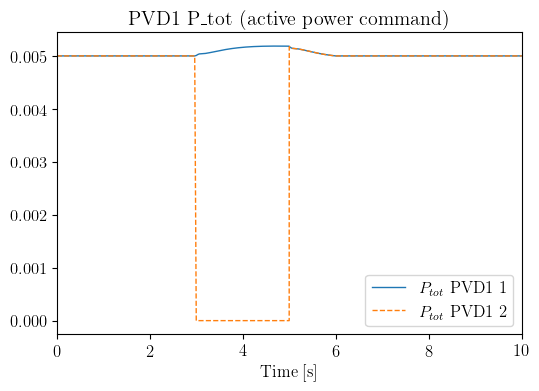

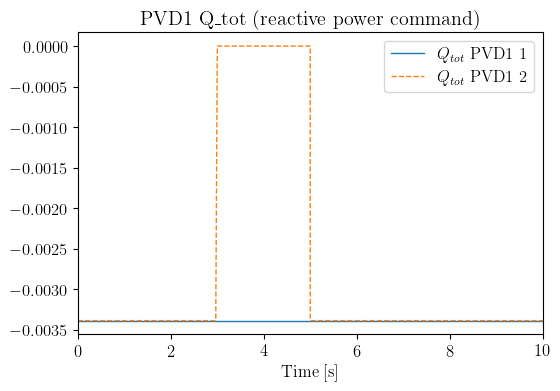

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'PVD1 Q\\_tot (reactive power command)'}, xlabel='Time [s]'>)

In [30]:
ss.TDS.plt.plot(ss.PVD1.Psum,
                a=(0,1),
                title='PVD1 P\_tot (active power command)')

ss.TDS.plt.plot(ss.PVD1.Qsum,
                a=(0,1),
                title='PVD1 Q\_tot (reactive power command)')

### PVD1_2 current command

Consequently, `PVD1_2` current commands are locked to 0 **immediately**.

Once the protection was released, they returned to normal **immediately**.

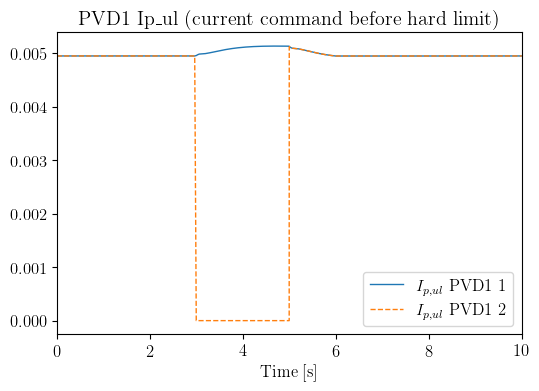

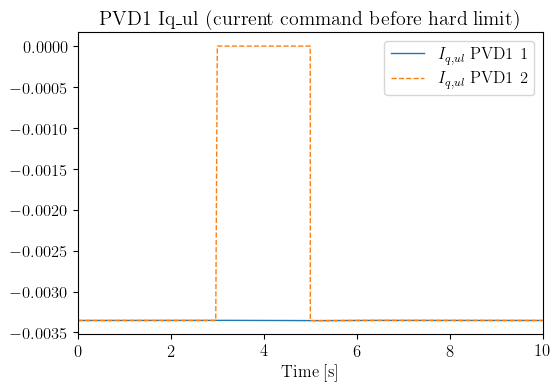

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'PVD1 Iq\\_ul (current command before hard limit)'}, xlabel='Time [s]'>)

In [31]:
ss.TDS.plt.plot(ss.PVD1.Ipul,
                a=(0,1),
                title='PVD1 Ip\_ul (current command before hard limit)')

ss.TDS.plt.plot(ss.PVD1.Iqul,
                a=(0,1),
                title='PVD1 Iq\_ul (current command before hard limit)')

### PVD1_2 output current

As a result, `PVD1_2` output current decreased to 0 **gradually**.

When the protection was released, they returned to normal **gradually**.

Here, the `PVD1` output current `Lag` time constant (`tip` and `tiq`) are modified to 0.5, which is only for observation.

Usually, power electronic device can response in ms level.

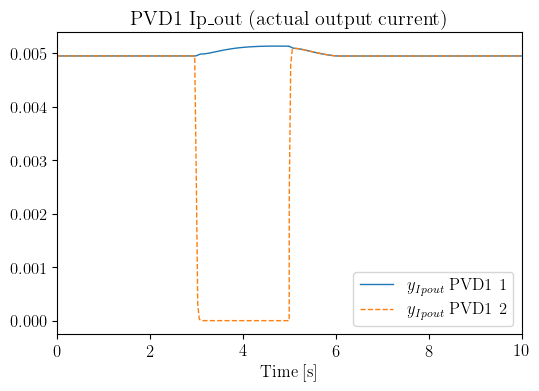

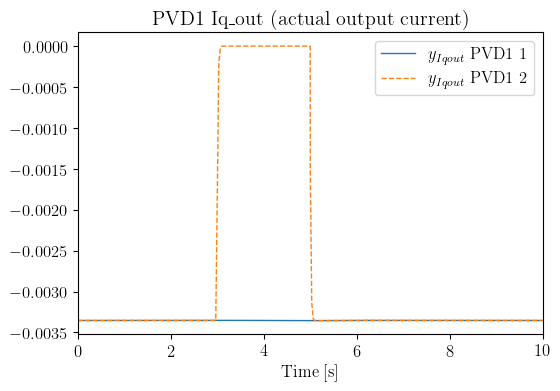

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'PVD1 Iq\\_out (actual output current)'}, xlabel='Time [s]'>)

In [32]:
ss.TDS.plt.plot(ss.PVD1.Ipout_y,
                a=(0,1),
                title='PVD1 Ip\_out (actual output current)')

ss.TDS.plt.plot(ss.PVD1.Iqout_y,
                a=(0,1),
                title='PVD1 Iq\_out (actual output current)')

## Cleanup

In [33]:
!andes misc -C


    _           _         | Version 1.4.0.post13+g69b17d2d
   /_\  _ _  __| |___ ___ | Python 3.7.10 on Linux, 09/12/2021 12:50:06 PM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

No output file found in the working directory.
